# The Object Detection Dataset

There are no small datasets, like MNIST or Fashion-MNIST, in the object detection field. In order to quickly test models, we are going to assemble a small dataset. First, we generate 1000 banana images of different angles and sizes using free bananas from our office. Then, we collect a series of background images and place a banana image at a random position on each image.

## Downloading the Dataset

The banana detection dataset in RecordIO format can be downloaded directly from the Internet.


In [1]:
%use @file[../djl.json]
@file:DependsOn("../D2J-1.0-SNAPSHOT.jar")
//import jp.live.ugai.d2j.attention.Chap10Utils
import jp.live.ugai.d2j.util.ImageUtils

In [2]:
import ai.djl.basicdataset.cv.*;
import java.awt.*;
import java.awt.image.*;
import javax.swing.*;
import ai.djl.modality.cv.output.Rectangle;
import ai.djl.modality.cv.Image

## Reading the Dataset

We are going to read the object detection dataset by creating the instance `BananaDetection`. DJL makes it fairly easy to get the dataset. Here is how we do it.

In [3]:
// Load the bananas dataset.
val trainIter = BananaDetection.builder()
        .setSampling(32, true)  // Read the dataset in random order
        .optUsage(Dataset.Usage.TRAIN)
        .build();

trainIter.prepare();

Below, we read a minibatch and print the shape of the image and label. The shape of the image is the same as in the previous experiment (batch size, number of channels, height, width). The shape of the label is (batch size, $m$, 5), where $m$ is equal to the maximum number of bounding boxes contained in a single image in the dataset. Although computation for the minibatch is very efficient, it requires each image to contain the same number of bounding boxes so that they can be placed in the same batch. Since each image may have a different number of bounding boxes, we can add illegal bounding boxes to images that have less than $m$ bounding boxes until each image contains $m$ bounding boxes. Thus, we can read a minibatch of images each time. The label of each bounding box in the image is represented by an array of length 5. The first element in the array is the category of the object contained in the bounding box. When the value is -1, the bounding box is an illegal bounding box for filling purpose. The remaining four elements of the array represent the $x, y$ axis coordinates of the upper-left corner of the bounding box and the $x, y$ axis coordinates of the lower-right corner of the bounding box (the value range is between 0 and 1). The banana dataset here has only one bounding box per image, so $m=1$.


In [4]:
val manager = NDManager.newBaseManager();

val batch = trainIter.getData(manager).iterator().next();
println(batch.getData().get(0).getShape().toString() + ", " + batch.getLabels().get(0).getShape());

(32, 3, 256, 256), (32, 1, 5)


## Demonstration

We have ten images with bounding boxes on them. We can see that the angle, size, and position of banana are different in each image. Of course, this is a simple artificial dataset. In actual practice, the data are usually much more complicated.


In [7]:
fun showImages(dataset: kotlin.collections.List<Image>, width: Int, height: Int): BufferedImage {
    val col = 1280 / width;
    val row = (dataset.size + col - 1) / col;
    val w = col * (width + 3);
    val h = row * (height + 3);
    val bi = BufferedImage(w + 3, h, BufferedImage.TYPE_INT_RGB);
    val g = bi.createGraphics();

    for (i in 0 until dataset.size) {
        val image = dataset[i];
        val x = (i % col) * (width + 3) + 3;
        val y = (i / col) * (height + 3) + 3;
        
        g.drawImage(image.getWrappedImage() as java.awt.Image , x, y, width, height, null);
    }
    g.dispose();
    return bi;
}


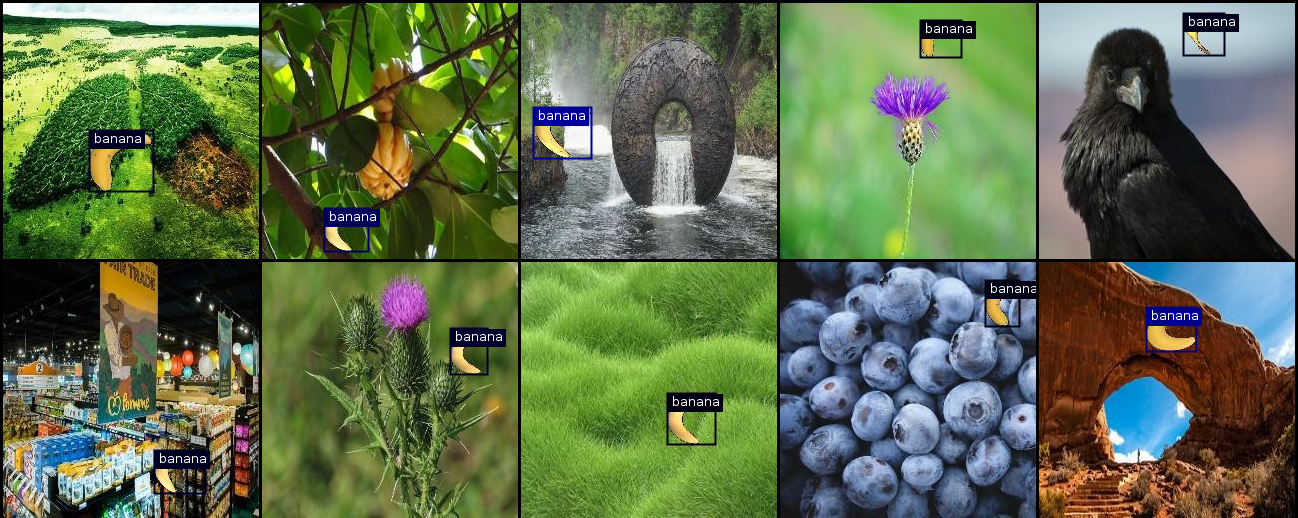

In [9]:
val imageArr = mutableListOf<Image>()
val classNames = mutableListOf<kotlin.collections.List<String>>()
val prob = mutableListOf<kotlin.collections.List<Double>>()
val boxes = mutableListOf<kotlin.collections.List<Rectangle>>()

val batch = trainIter.getData(manager).iterator().next();
for (i in 0 until 10) {
    val imgData = batch.getData().get(0).get(i.toLong());
    imgData.muli(255);
    val imgLabel = batch.getLabels().get(0).get(i.toLong());

    val bananaList = listOf("banana")
    classNames.add(bananaList)

    val probabilityList = listOf(1.0)
    prob.add(probabilityList)

    val coord = imgLabel.get(0).toFloatArray();
    val first = coord[1]
    val second = coord[2]
    val third = coord[3]
    val fourth = coord[4]

    val boundBoxes = mutableListOf<Rectangle>(Rectangle(first.toDouble(), second.toDouble(), (third-first).toDouble(), (fourth-second).toDouble()))

    boxes.add(boundBoxes)
    val detectedObjects = DetectedObjects(classNames.get(i), prob.get(i), boxes.get(i));
    val timage = ImageFactory.getInstance().fromNDArray(imgData.toType(DataType.INT8, true))
    timage.drawBoundingBoxes(detectedObjects)
    imageArr.add(timage)
}

// refer to https://github.com/deepjavalibrary/d2l-java/tree/master/documentation/troubleshoot.md 
// if you encounter X11 errors when drawing bounding boxes.
showImages(imageArr, 256, 256)

## Summary

* The banana detection dataset we synthesized can be used to test object detection models.
* The data reading for object detection is similar to that for image classification. However, after we introduce bounding boxes, the label shape and image augmentation (e.g., random cropping) are changed.
